In [57]:
from scipy.stats import norm, uniform, weibull_min, expon
import numpy as np
import pandas as pd

# Process parameters
# σ^2 = 2Dt so the diffusion constants are D = 1/2 and D = 1/2 * (10)^(1/2)

sd = 1
n = 100
N = 2*10**4

# Make the dataset by generating the displacements and then taking a cumulative sum to obtain the trajectories.
x1 = uniform.rvs(scale = 50, size = (N, 1))
x2 = weibull_min.rvs(c = 1/2, size = (N,1))
# x2 = expon.rvs(scale = 3, size = (N, 1))
x3 = norm.rvs(size = (N, n-1), scale = sd)
x3 = x2*x3
data1 = np.cumsum(np.concatenate((x1,x3),axis=1), axis=1)
data1 = np.concatenate((x2, data1), axis=1)

df = pd.DataFrame(data1, 
                  columns = ['diffusion_constant'] + [ 't_' + str(i) for i in range(n)],
                  #index = None
                 )

# Divide the dataset in training validation and test sets
from sklearn.model_selection import train_test_split

# This line caused problems
# df['diffusion_constant'] = df['diffusion_constant'].astype('category')

train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

12800 train examples
3200 validation examples
4000 test examples


In [58]:
df

,diffusion_constant,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,14.583774,1.579112,-15.881380,-3.565181,-9.447858,-13.190602,-7.952618,1.675657,4.344882,2.875360,...,-112.657780,-119.145621,-115.692897,-121.963796,-137.286288,-133.015506,-132.465420,-131.238225,-110.821474,-103.983122
1,0.048264,47.784466,47.870946,47.800355,47.799488,47.907497,47.954779,47.976095,47.959800,47.904197,...,48.385198,48.368287,48.310994,48.325196,48.251596,48.195115,48.145728,48.116549,48.125695,48.165077
2,0.000382,6.960900,6.960727,6.960801,6.961295,6.961037,6.960508,6.960152,6.960267,6.960622,...,6.959942,6.960877,6.961279,6.961877,6.961864,6.962837,6.963104,6.963838,6.962898,6.962792
3,0.082009,5.616976,5.583266,5.501528,5.468867,5.414350,5.371711,5.314671,5.452034,5.426321,...,4.572427,4.389158,4.431692,4.475182,4.441426,4.509320,4.542932,4.479171,4.515453,4.663701
4,0.638773,12.257099,12.758520,12.331611,12.278368,13.014701,13.455000,13.434588,12.852350,13.256533,...,19.538562,19.317156,18.911835,19.209195,19.967316,20.058671,20.531933,20.501777,21.011098,21.810432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.493165,27.943842,27.595904,27.150871,27.376157,27.500195,27.715300,27.720474,27.492478,27.644329,...,27.432324,27.406073,27.008218,26.735601,26.850312,26.822775,26.992694,26.847149,26.730296,26.561948
19996,2.818466,30.931875,31.084246,31.909035,34.589457,35.307787,34.332356,34.451615,29.683774,29.542068,...,55.455133,58.530440,58.940427,62.647678,65.126798,64.471896,66.493083,64.010739,67.102612,69.455878
19997,0.068095,30.374129,30.405842,30.470323,30.464604,30.432361,30.421376,30.329133,30.454327,30.504513,...,31.010524,30.916171,30.883502,30.813805,30.650768,30.720722,30.636527,30.682656,30.702864,30.666487
19998,0.314185,6.650975,7.371679,7.746372,7.516770,7.710316,7.528710,7.525602,7.755597,8.210517,...,14.200742,13.840597,13.490581,13.120787,13.641652,14.079552,13.681330,13.940030,14.289015,14.276457


In [59]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [60]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('diffusion_constant')
    # labels = pd.DataFrame([[0,1] if (row == 1) else [1,0] for row in labels])
    ds = tf.data.Dataset.from_tensor_slices((dataframe.values, labels.values))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Turn pandas dataframes into tensorflow tensor datasets
batch_size = 100 
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

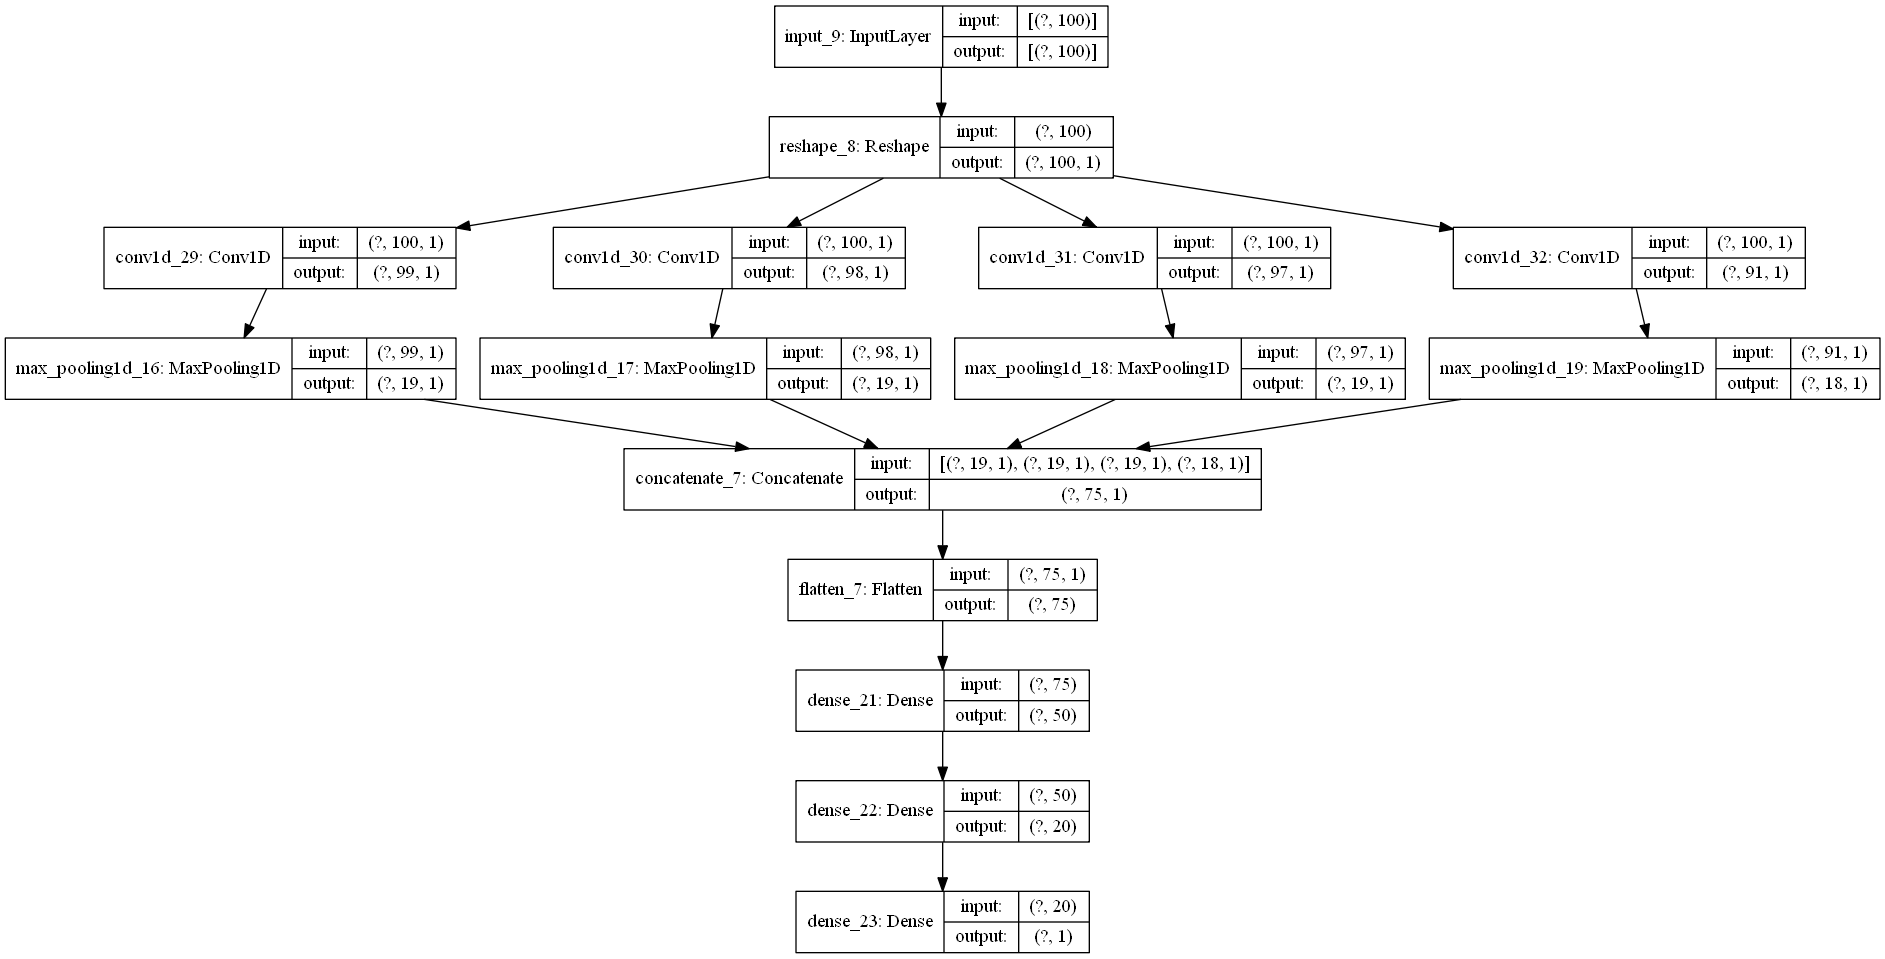

In [61]:
# Define the neural network model

from tensorflow import keras
# from functools import partial


def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.01)

activation = 'elu'

input = keras.Input(shape = (n, ))
reshape = tf.keras.layers.Reshape(target_shape = (n, 1, ), input_shape=(n, ))(input)

conv1 = keras.layers.Conv1D(filters = 1, input_shape = (None, n, 1), kernel_size = 2, trainable = False, use_bias = False, activation = None)(reshape)
conv1 = keras.layers.MaxPooling1D(pool_size = 5)(conv1)

conv2 = keras.layers.Conv1D(filters = 1, input_shape = (None, n, 1), kernel_size = 3, trainable = False, use_bias = False, activation = None)(reshape)
conv2 = keras.layers.MaxPooling1D(pool_size = 5)(conv2)

conv3 = keras.layers.Conv1D(filters = 1, input_shape = (None, n, 1), kernel_size = 4, trainable = False, use_bias = False, activation = None)(reshape)
conv3 = keras.layers.MaxPooling1D(pool_size = 5)(conv3)

conv4 = keras.layers.Conv1D(filters = 1, input_shape = (None, n, 1), kernel_size = 10, trainable = False, use_bias = False, activation = None)(reshape)
conv4 = keras.layers.MaxPooling1D(pool_size = 5)(conv4)

x = keras.layers.Concatenate(axis = 1)(inputs = [conv1, conv2, conv3, conv4])
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(50, activation=activation)(x)
x = keras.layers.Dense(20, activation=activation)(x)
x = keras.layers.Dense(1, activation=activation)(x)

model = keras.Model(inputs=input, outputs=x, name="diffusion")
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

filter1 = np.array([-1,1]).reshape(2,1,1)
filter2 = np.array([-1, 0, 1]).reshape(3,1,1)
filter3 = np.array([-1, 0, 0, 1]).reshape(4,1,1)
filter4 = np.array([-1, 0, 0, 0, 0, 0, 0, 0, 0, 1]).reshape(10,1,1)

model.layers[2].set_weights([filter1])
model.layers[3].set_weights([filter2])
model.layers[4].set_weights([filter3])
model.layers[5].set_weights([filter4])

keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)


In [62]:
model.summary()

Model: "diffusion"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 100, 1)       0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 99, 1)        2           reshape_8[0][0]                  
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 98, 1)        3           reshape_8[0][0]                  
__________________________________________________________________________________________

In [63]:
model.compile(
    optimizer = 'adam',
#     loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    loss = tf.keras.losses.MeanAbsolutePercentageError(),
    metrics = ['MeanAbsolutePercentageError']
)

In [64]:
# Tensorboard can be used to view several aspects of the trained model. Using it in a Jupyter notebook is not recommended, since the output is small on screen. 
# %load_ext tensorboard

# # Clear any logs from previous runs
# !rm -rf ./logs/ # CHECK IF NOTHING IMPORTANT IS HERE

# import datetime
# log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 30)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(
    train_ds,
    validation_data = val_ds,
    callbacks = [es, mc], #tensorboard_callback
    epochs = 4000,
    verbose = 0
#     callbacks = [tensorboard_callback]
)


Epoch 00001: val_loss improved from inf to 4441.94543, saving model to best_model.h5

Epoch 00002: val_loss improved from 4441.94543 to 749.88241, saving model to best_model.h5

Epoch 00003: val_loss did not improve from 749.88241

Epoch 00004: val_loss improved from 749.88241 to 455.35165, saving model to best_model.h5

Epoch 00005: val_loss improved from 455.35165 to 397.07096, saving model to best_model.h5

Epoch 00006: val_loss did not improve from 397.07096

Epoch 00007: val_loss did not improve from 397.07096

Epoch 00008: val_loss did not improve from 397.07096

Epoch 00009: val_loss did not improve from 397.07096

Epoch 00010: val_loss did not improve from 397.07096

Epoch 00011: val_loss did not improve from 397.07096

Epoch 00012: val_loss did not improve from 397.07096

Epoch 00013: val_loss did not improve from 397.07096

Epoch 00014: val_loss did not improve from 397.07096

Epoch 00015: val_loss did not improve from 397.07096

Epoch 00016: val_loss did not improve from 39

In [38]:
# For an in browser view in a seperate tab go to localhost:PORT_NUMBER, typically localhost:6006
# %tensorboard --logdir logs/fit

In [39]:
model = keras.models.load_model('best_model.h5')
model.evaluate(test_ds)

40/40 [==============================] - 0s 7ms/step - loss: 7.3643 - MeanAbsolutePercentageError: 7.3643


[7.3642912864685055, 7.364292]

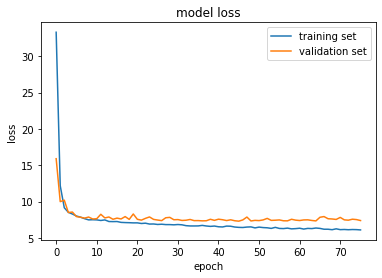

In [41]:
from matplotlib import pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [18]:
# Print the names, sizes and layer index of the convolutional layers
for number, layer in enumerate(model.layers):
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape, " on layer: ", number)

ValueError: not enough values to unpack (expected 2, got 1)

In [42]:
# retrieve filter weights from the second hidden layer
# filters, biases = model.layers[4].get_weights()
model.layers[5].get_weights()
# print(filters)

[array([[[-1.]],
 
        [[ 0.]],
 
        [[ 0.]],
 
        [[ 0.]],
 
        [[ 0.]],
 
        [[ 0.]],
 
        [[ 0.]],
 
        [[ 0.]],
 
        [[ 0.]],
 
        [[ 1.]]], dtype=float32)]

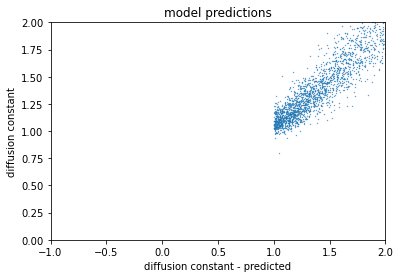

In [43]:
# Plot model predictions for all trajectories in the dataset

predictions = model.predict(test.iloc[:,1:])
plt.scatter(
    y = predictions,
    x = test.iloc[:,0],
    s = .1,
)
# plt.legend(loc = 'upper right')
plt.xlim(-1, 2)
plt.ylim(0, 2)
plt.title('model predictions')
plt.ylabel('diffusion constant')
plt.xlabel('diffusion constant - predicted')
plt.show()

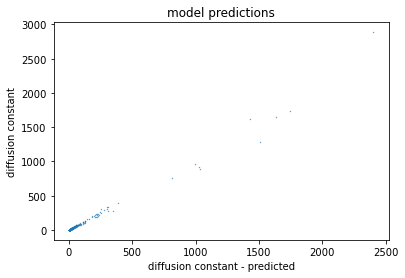

In [30]:
predictions = model.predict(test.iloc[:,1:])
plt.scatter(
    y = predictions,
    x = test.iloc[:,0],
    s = .1
)
# plt.legend(loc = 'upper right')
plt.title('model predictions')
plt.ylabel('diffusion constant')
plt.xlabel('diffusion constant - predicted')
plt.show()